<a href="https://colab.research.google.com/github/TNguyen2k3/BTL2_AI-Tic_tac_toe/blob/kd-branch/Bot_AI_BTL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tf2onnx onnx onnxruntime numpy

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, utils, callbacks
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
#%% Define the model building function
def build_model(input_shape=(9, 9, 1), num_policy_outputs=81):
    input_board = layers.Input(shape=input_shape, name="board_input")

    # Convolutional block 1
    x = layers.Conv2D(64, (3, 3), padding='same', name="conv1")(input_board)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.Activation('relu', name="relu1")(x)

    # Convolutional block 2
    x = layers.Conv2D(128, (3, 3), padding='same', name="conv2")(x)
    x = layers.BatchNormalization(name="bn2")(x)
    x = layers.Activation('relu', name="relu2")(x)

    x = layers.Flatten(name="flatten")(x)

    # Policy head
    policy_hidden = layers.Dense(128, name="policy_hidden")(x)
    policy_hidden = layers.BatchNormalization(name="policy_bn")(policy_hidden)
    policy_hidden = layers.Activation('relu', name="policy_relu")(policy_hidden)
    policy_output = layers.Dense(num_policy_outputs, activation='softmax', name="policy_output")(policy_hidden)

    # Value head
    value_hidden = layers.Dense(64, name="value_hidden")(x)
    value_hidden = layers.BatchNormalization(name="value_bn")(value_hidden)
    value_hidden = layers.Activation('relu', name="value_relu")(value_hidden)
    value_output = layers.Dense(1, activation='tanh', name="value_output")(value_hidden)

    model = models.Model(inputs=input_board, outputs=[policy_output, value_output])
    return model

In [ ]:
import numpy as np
from tensorflow.keras import utils

def check_win_caro(board, player):
    """
    Kiểm tra xem người chơi `player` có thắng trên `board` hay không.
    Đây là một hàm kiểm tra thắng đơn giản, có thể cần cải thiện cho trường hợp phức tạp.
    Board là mảng 2D (9x9).
    """
    rows, cols = board.shape
    # Kiểm tra hàng ngang
    for r in range(rows):
        for c in range(cols - 4):
            if np.all(board[r, c:c+5] == player):
                return True
    # Kiểm tra hàng dọc
    for c in range(cols):
        for r in range(rows - 4):
            if np.all(board[r:r+5, c] == player):
                return True
    # Kiểm tra đường chéo chính (từ trên trái xuống dưới phải)
    for r in range(rows - 4):
        for c in range(cols - 4):
            if np.all(np.diag(board[r:r+5, c:c+5]) == player):
                return True
    # Kiểm tra đường chéo phụ (từ trên phải xuống dưới trái)
    for r in range(rows - 4):
        for c in range(4, cols):
            sub_board = board[r:r+5, c-4:c+1]
            if np.all(np.diag(np.fliplr(sub_board)) == player):
                return True
    return False


def generate_constrained_dummy_data(num_samples=1000, board_size=9, win_condition=5):
    input_shape = (board_size, board_size, 1)
    num_policy_outputs = board_size * board_size

    X_all = []
    y_policy_all = []
    y_value_all = []

    for _ in range(num_samples):
        board = np.zeros((board_size, board_size), dtype=np.int8) # 0: trống, 1: player 1, -1: player 2

        # Tạo một trạng thái bàn cờ ngẫu nhiên nhưng "hợp lý" hơn một chút
        num_moves_to_play = np.random.randint(1, num_policy_outputs // 2) # Chơi một số nước ngẫu nhiên
        current_player = 1
        game_over = False
        winner = 0
        for _ in range(num_moves_to_play):
            empty_cells_indices = np.where(board.flatten() == 0)[0]
            if len(empty_cells_indices) == 0:
                game_over = True
                break

            random_move_index = np.random.choice(empty_cells_indices)
            row, col = np.unravel_index(random_move_index, (board_size, board_size))
            board[row, col] = current_player

            # Kiểm tra thắng sau mỗi nước đi (đơn giản hóa)
            if check_win_caro(board, current_player):
                game_over = True
                winner = current_player
                break

            current_player *= -1


        X_board = board.astype(np.float32).reshape(input_shape)
        X_all.append(X_board)

        valid_moves_policy = np.zeros(num_policy_outputs, dtype=np.float32)
        if not game_over:
            empty_cells_for_policy = np.where(board.flatten() == 0)[0]
            if len(empty_cells_for_policy) > 0:
                chosen_policy_move_index = np.random.choice(empty_cells_for_policy)
                valid_moves_policy[chosen_policy_move_index] = 1.0
            else:
                pass
        else:
            pass
        y_policy_all.append(valid_moves_policy)
        value_target = 0.0
        if winner == 1:
            value_target = 1.0
        elif winner == -1:
            value_target = -1.0
        elif game_over and winner == 0:
            value_target = 0.0
        else:
            value_target = np.random.uniform(-0.7, 0.7) # Giá trị ngẫu nhiên nhưng không quá cực đoan
        y_value_all.append(np.array([value_target], dtype=np.float32))

    return np.array(X_all), {"policy_output": np.array(y_policy_all), "value_output": np.array(y_value_all)}

In [ ]:
#%% Configure training parameters and build the model
INPUT_SHAPE = (9, 9, 1)
NUM_POLICY_OUTPUTS = 9 * 9 # 81 possible moves on a 9x9 board

# Build the model
model = build_model(input_shape=INPUT_SHAPE, num_policy_outputs=NUM_POLICY_OUTPUTS)

# Optimizer: Adam with a potentially customizable learning rate
optimizer = optimizers.Adam(learning_rate=0.001) # Default is 0.001

# Compile the model
model.compile(
    optimizer=optimizer,
    loss={
        'policy_output': losses.CategoricalCrossentropy(),
        'value_output': losses.MeanSquaredError() # or 'mse'
    },
    loss_weights={ # Optional: Adjust the importance of each loss
        'policy_output': 1.0,
        'value_output': 0.75  # Example: Slightly less weight on value loss
    },
    metrics={
        'policy_output': metrics.CategoricalAccuracy(name="policy_accuracy"),
        'value_output': metrics.MeanAbsoluteError(name="value_mae")
    }
)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ board_input         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 9, 9, 64)  │        640 │ board_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 9, 9, 64)  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (Activation)  │ (None, 9, 9, 64)  │          0 │ bn1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 9, 9, 128) │     73,856 │ relu1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 9, 9, 128) │        512 │ conv2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu2 (Activation)  │ (None, 9, 9, 128) │          0 │ bn2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10368)     │          0 │ relu2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ policy_hidden       │ (None, 128)       │  1,327,232 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_hidden        │ (None, 64)        │    663,616 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ policy_bn           │ (None, 128)       │        512 │ policy_hidden[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_bn            │ (None, 64)        │        256 │ value_hidden[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ policy_relu         │ (None, 128)       │          0 │ policy_bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_relu          │ (None, 64)        │          0 │ value_bn[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ policy_output       │ (None, 81)        │     10,449 │ policy_relu[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_output        │ (None, 1)         │         65 │ value_relu[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,077,394 (7.92 MB)

 Trainable params: 2,076,626 (7.92 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
#%% Generate dummy training and validation data
print("\n--- Generating Dummy Data ---")
NUM_SAMPLES = 5000
X_data, y_data_dict = generate_constrained_dummy_data(num_samples=NUM_SAMPLES,
                                         board_size=9,
                                         win_condition=5)
print(f"X_data shape: {X_data.shape}")
print(f"y_policy shape: {y_data_dict['policy_output'].shape}")
print(f"y_value shape: {y_data_dict['value_output'].shape}")

In [ ]:
#%% Define Callbacks for training

log_dir = "logs/fit/"
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Model Checkpoint: Save the best model
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Use .weights.h5 for saving only weights, or .keras for the whole model
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model_weights.{epoch:02d}-{val_loss:.2f}.weights.h5"),
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Early Stopping: Stop training if no improvement
early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Reduce Learning Rate on Plateau: Reduce learning rate when a metric has stopped improving
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=7,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

training_callbacks = [
    model_checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback
]

In [ ]:
#%% Train the model
print("\n--- Starting Training ---")
EPOCHS = 100
BATCH_SIZE = 64

history = model.fit(
    X_data,
    y_data_dict,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=training_callbacks,
    verbose=1
)

print("\n--- Training Finished ---")


--- Starting Training ---
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.0963 - policy_output_loss: 4.5675 - policy_output_policy_accuracy: 0.0117 - value_output_loss: 0.7051 - value_output_value_mae: 0.7060
Epoch 1: val_loss improved from inf to 4.52154, saving model to checkpoints/best_model_weights.01-4.52.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 5.0929 - policy_output_loss: 4.5665 - policy_output_policy_accuracy: 0.0117 - value_output_loss: 0.7019 - value_output_value_mae: 0.7040 - val_loss: 4.5215 - val_policy_output_loss: 4.3551 - val_policy_output_policy_accuracy: 0.0120 - val_value_output_loss: 0.2211 - val_value_output_value_mae: 0.3962 - learning_rate: 0.0010
Epoch 2/100
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0527 - policy_output_loss: 3.9167 - policy_output_policy_accuracy: 0.1352 - value_output_loss: 0.1813 - value_output_value_mae: 0.3523
Epoch 2: val_loss improved from 4.52154 to 4.49218, saving model to checkpoints/best_model_

In [ ]:
print("Các khóa có trong history.history:")
print(history.history.keys())

Các khóa có trong history.history:
dict_keys(['loss', 'policy_output_loss', 'policy_output_policy_accuracy', 'val_loss', 'val_policy_output_loss', 'val_policy_output_policy_accuracy', 'val_value_output_loss', 'val_value_output_value_mae', 'value_output_loss', 'value_output_value_mae', 'learning_rate'])


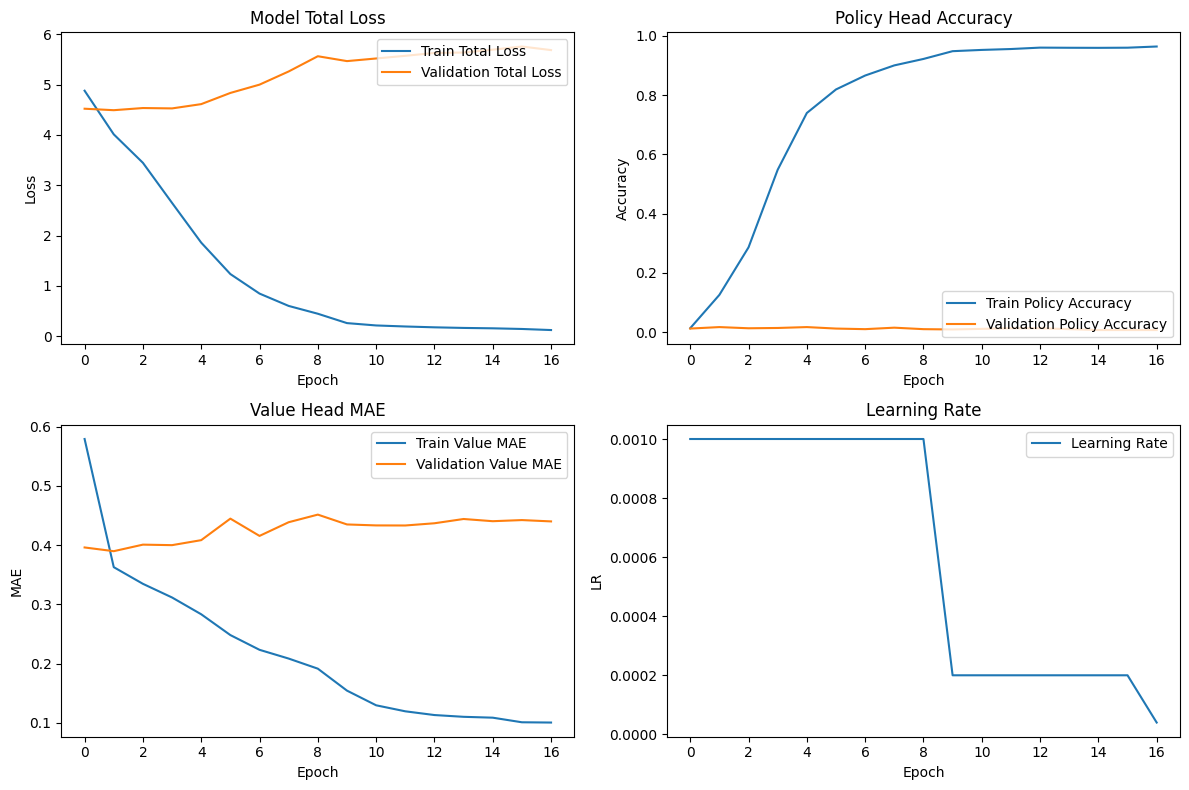


--- Final Metrics (Lấy từ history.history) ---
Final Training Total Loss: 0.12110432982444763
Final Validation Total Loss: 5.687218189239502
Final Training Policy Accuracy (policy_output_policy_accuracy): 0.9645000100135803
Final Validation Policy Accuracy (val_policy_output_policy_accuracy): 0.007000000216066837
Final Training Value MAE (value_output_value_mae): 0.10054989904165268
Final Validation Value MAE (val_value_output_value_mae): 0.4401981234550476
Final Training Policy Loss: 0.10618284344673157
Final Validation Policy Loss: 5.475883483886719
Final Training Value Loss: 0.02051720954477787
Final Validation Value Loss: 0.2815488576889038
Final Learning Rate: 4.0000002627493814e-05


In [ ]:
#%% Plot training history


def plot_history(history):
    history_dict = history.history # Lấy dictionary từ history object


    train_policy_acc_key = 'policy_output_policy_accuracy'
    val_policy_acc_key = 'val_policy_output_policy_accuracy'
    train_value_mae_key = 'value_output_value_mae'
    val_value_mae_key = 'val_value_output_value_mae'

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    if 'loss' in history_dict:
        plt.plot(history_dict['loss'], label='Train Total Loss')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Validation Total Loss')
    plt.title('Model Total Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot policy accuracy
    plt.subplot(2, 2, 2)
    if train_policy_acc_key in history_dict:
        plt.plot(history_dict[train_policy_acc_key], label='Train Policy Accuracy')
    if val_policy_acc_key in history_dict:
        plt.plot(history_dict[val_policy_acc_key], label='Validation Policy Accuracy')
    plt.title('Policy Head Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot value MAE
    plt.subplot(2, 2, 3)
    if train_value_mae_key in history_dict:
        plt.plot(history_dict[train_value_mae_key], label='Train Value MAE')
    if val_value_mae_key in history_dict:
        plt.plot(history_dict[val_value_mae_key], label='Validation Value MAE')
    plt.title('Value Head MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot learning rate
    if 'learning_rate' in history_dict:
        lr_key = 'learning_rate' if 'learning_rate' in history_dict else 'lr'
        plt.subplot(2, 2, 4)
        plt.plot(history_dict[lr_key], label='Learning Rate')
        plt.title('Learning Rate')
        plt.ylabel('LR')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_history(history)
print("\n--- Final Metrics (Lấy từ history.history) ---")


final_loss = history.history['loss'][-1] if 'loss' in history.history else 'N/A'
final_val_loss = history.history['val_loss'][-1] if 'val_loss' in history.history else 'N/A'
print(f"Final Training Total Loss: {final_loss}")
print(f"Final Validation Total Loss: {final_val_loss}")

key_train_policy_acc = 'policy_output_policy_accuracy'
key_val_policy_acc = 'val_policy_output_policy_accuracy'
final_train_policy_acc = history.history[key_train_policy_acc][-1] if key_train_policy_acc in history.history else 'N/A'
final_val_policy_acc = history.history[key_val_policy_acc][-1] if key_val_policy_acc in history.history else 'N/A'
print(f"Final Training Policy Accuracy ({key_train_policy_acc}): {final_train_policy_acc}")
print(f"Final Validation Policy Accuracy ({key_val_policy_acc}): {final_val_policy_acc}")

key_train_value_mae = 'value_output_value_mae'
key_val_value_mae = 'val_value_output_value_mae'
final_train_value_mae = history.history[key_train_value_mae][-1] if key_train_value_mae in history.history else 'N/A'
final_val_value_mae = history.history[key_val_value_mae][-1] if key_val_value_mae in history.history else 'N/A'
print(f"Final Training Value MAE ({key_train_value_mae}): {final_train_value_mae}")
print(f"Final Validation Value MAE ({key_val_value_mae}): {final_val_value_mae}")

# In thêm các loss riêng của từng head nếu có
if 'policy_output_loss' in history.history:
    print(f"Final Training Policy Loss: {history.history['policy_output_loss'][-1]}")
if 'val_policy_output_loss' in history.history:
    print(f"Final Validation Policy Loss: {history.history['val_policy_output_loss'][-1]}")

if 'value_output_loss' in history.history:
    print(f"Final Training Value Loss: {history.history['value_output_loss'][-1]}")
if 'val_value_output_loss' in history.history:
    print(f"Final Validation Value Loss: {history.history['val_value_output_loss'][-1]}")

if 'learning_rate' in history.history:
    print(f"Final Learning Rate: {history.history['learning_rate'][-1]}")
elif 'lr' in history.history:
     print(f"Final Learning Rate: {history.history['lr'][-1]}")

In [ ]:

print("\n--- Example Prediction with the current model state ---")
X_sample, _ = generate_dummy_data(num_samples=1,
                                 input_shape=INPUT_SHAPE,
                                 num_policy_outputs=NUM_POLICY_OUTPUTS)

predicted_policy, predicted_value = model.predict(X_sample)

print(f"Sample input board shape: {X_sample.shape}")
print(f"Predicted policy shape: {predicted_policy.shape}")
print(f"Predicted policy (first 10 elements): {predicted_policy[0, :10]}")
print(f"Sum of predicted policy: {np.sum(predicted_policy[0]):.4f}")
print(f"Predicted value: {predicted_value[0,0]:.4f}")
print(f"Argmax of predicted policy (chosen move index): {np.argmax(predicted_policy[0])}")

In [ ]:
# 4. Lưu model dưới dạng .h5
model.save("caro_bot.keras")

In [ ]:
import tf2onnx

keras_model = tf.keras.models.load_model("caro_bot.keras")
spec = (tf.TensorSpec((None, 9, 9, 1), tf.float32, name="board_input"),)
onnx_model, _ = tf2onnx.convert.from_keras(keras_model, input_signature=spec, output_path="caro_bot.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7ee2226c0540>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


In [ ]:
import onnx
onnx_model = onnx.load("caro_bot.onnx")
onnx.checker.check_model(onnx_model)
print("✅ Model ONNX hợp lệ!")

✅ Model ONNX hợp lệ!


In [ ]:

from google.colab import files
files.download("caro_bot.onnx")

FileNotFoundError: Cannot find file: caro_bot.onnx